In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# sample symbols
# a = ["QBTS"]

# Conditions
# Range breakout + Volume surge + Moving average
# RSI overbought


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

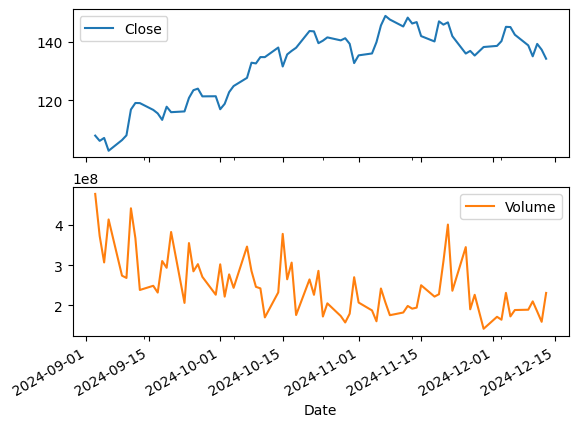

In [99]:
qbts = yf.download("NVDA", start='2024-09-01', progress=False, rounding=2)
qbts[["Close", "Volume"]].plot(subplots=True, kind="line")

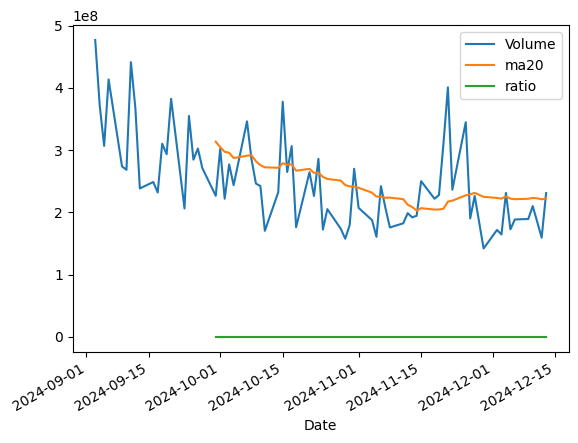

In [100]:
condition_vol = []
vol = qbts[['Volume']]
vol['ma20'] = vol['Volume'].rolling(20).mean()
vol['ratio'] = vol['Volume']/vol['ma20']
vol.plot()
for i in range(len(vol)):
    if vol['ratio'].iloc[i] >= 2.4:
        plt.axvline(x=vol.index[i], color='red')
        print(vol.index[i])
        condition_vol.append(vol.index[i])

2024-10-04 00:00:00
2024-10-07 00:00:00
2024-10-08 00:00:00
2024-10-09 00:00:00
2024-10-10 00:00:00
2024-10-11 00:00:00
2024-10-14 00:00:00
2024-10-21 00:00:00
2024-10-22 00:00:00
2024-11-06 00:00:00
2024-11-07 00:00:00
2024-11-08 00:00:00


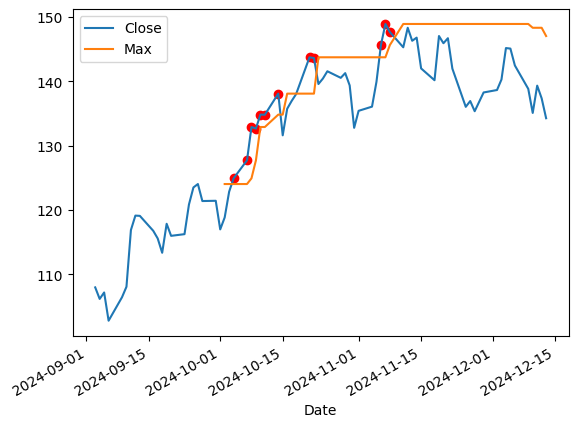

In [101]:
condition_price = []
price = qbts[['Close']]
price['Max'] = price['Close'].rolling(20).max()
price['Max'] = price['Max'].shift(2)
price.plot()
for i in range(len(price)):
    if price['Max'].iloc[i] < price['Close'].iloc[i]:
        plt.scatter(price.index[i], price['Close'].iloc[i], color='red')
        print(price.index[i])
        condition_price.append(price.index[i])


In [102]:
final = []
first = 0
for i in condition_vol:
    if i in condition_price:
        print(i)
        if first == 0: 
            first = i
            final.append(i)
        else:
            if (i - first).days >= 30:
                first = i
                final.append(i)
            else:
                continue
final

[]

In [103]:
price_bt = qbts[['Open']]
price_bt['Open_s20'] = price_bt['Open'].shift(-20)
price_bt.ffill(inplace=True)
price_bt['Entry'] = price_bt.apply(lambda x: 1 if x.name in final else 0, axis=1)
price_bt['Entry'] = price_bt['Entry'].shift(1)
price_bt_traded = price_bt[price_bt['Entry'] == 1]
price_bt_traded['profit'] = price_bt_traded.apply(lambda x: x["Open_s20"]/x['Open']-1, axis=1)
price_bt_traded['profit']

Series([], Name: profit, dtype: float64)

In [118]:
def penny_stock_range_breakout_2f(
        symbol='QBTS', 
        start='2024-09-01', 
        hold=20, 
        price_bo_period=20,
        vol_ma_period=20,
        vol_ratio=2.4):
    
    qbts = yf.download(symbol, start=start, progress=False)
    # Volume Surge
    condition_vol = []
    vol = qbts[['Volume']]
    vol['ma20'] = vol['Volume'].rolling(vol_ma_period).mean()
    vol['ratio'] = vol['Volume']/vol['ma20']
    for i in range(len(vol)):
        if vol['ratio'].iloc[i] >= vol_ratio:
            condition_vol.append(vol.index[i])

    # Price breakout 
    condition_price = []
    price = qbts[['Close']]
    price['Max'] = price['Close'].rolling(price_bo_period).max()
    price['Max'] = price['Max'].shift(2)
    for i in range(len(price)):
        if price['Max'].iloc[i] < price['Close'].iloc[i]:
            condition_price.append(price.index[i])

    # day of signal
    final = []
    first = 0
    for i in condition_vol:
        if i in condition_price:
            if first == 0: 
                first = i
                final.append(i)
            else:
                if (i - first).days >= 30:
                    first = i
                    final.append(i)
                else:
                    continue

    # Rate of success
    price_bt = qbts[['Open']]
    price_bt['Open_s20'] = price_bt['Open'].shift(-hold)
    price_bt.ffill(inplace=True)
    price_bt['Entry'] = price_bt.apply(lambda x: 1 if x.name in final else 0, axis=1)
    price_bt['Entry'] = price_bt['Entry'].shift(1)
    price_bt_traded = price_bt[price_bt['Entry'] == 1]
    price_bt_traded['profit'] = price_bt_traded.apply(lambda x: x["Open_s20"]/x['Open']-1, axis=1)
    price_bt_traded['Symbol'] = symbol
    return price_bt_traded.iloc[:, [0, 1, 3, 4]]

df_list = []
for i in ['QBTS', "NVDA"]:
    df = penny_stock_range_breakout_2f(symbol=i)
    df_list.append(df)
pd.concat(df_list)

,Open,Open_s20,profit,Symbol
Date,,,,
2024-10-17,1.07,1.76,0.644860,QBTS
2024-11-22,2.24,3.97,0.772321,QBTS


In [ ]:
# Backtest P-value analyzer
